# Prediction in Machine Failure

Unexpected machine breakdown is one of the uncertainties that cause catastrophic consequences on the JSS. We are going to use ML techniques to build a prediction model then apply it to the simulation part, finally realizing the real-time data-driven optimizition in JSS.

We got the dataset from UCI Machine Learning Repository, which reflects real predictive maintenance data encountered in industry. It consists of 10,000 data points stored as rows with features like product type, air temperature, process temperature, rotational speed, torque wear, machine failure. The machine failures are grouped into 5 subcategories.

To implement ML techniques and work on historical data of the machine, we go through data cleaning, data visualization and analyzing, training and testing predictions respectively.

Machine Learning Method: Random forest, XGboost 

### Data Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import graphviz

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from six import StringIO  
from sklearn import metrics, tree
from IPython.display import Image  
import pydotplus 

In [4]:
import os 
os.environ["PATH"] += os.pathsep +  'C:\Program Files\Graphviz\bin'

In [5]:
import sklearn
print(sklearn.__version__)

1.2.1


In [11]:
df = pd.read_csv('ai4i2020.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [12]:
df.skew()

C:\Users\ODY1SZH\AppData\Local\Temp\ipykernel_4388\1665899112.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


UDI                         0.000000
Air temperature [K]         0.114274
Process temperature [K]     0.015027
Rotational speed [rpm]      1.993171
Torque [Nm]                -0.009517
Tool wear [min]             0.027292
Machine failure             5.151852
TWF                        14.644462
HDF                         9.164789
PWF                        10.114516
OSF                         9.953916
RNF                        22.879570
dtype: float64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### Data Visualization

machine failure rate

<AxesSubplot: ylabel='RNF'>

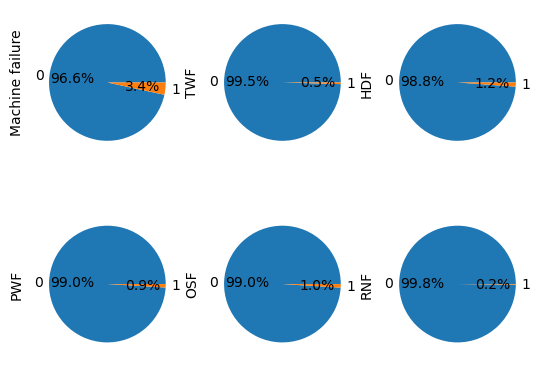

In [14]:
plt.subplot(2,3,1)
df['Machine failure'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.subplot(2,3,2)
df['TWF'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.subplot(2,3,3)
df['HDF'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.subplot(2,3,4)
df['PWF'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.subplot(2,3,5)
df['OSF'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.subplot(2,3,6)
df['RNF'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [15]:
df[df['Machine failure'] == 1][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].apply(pd.value_counts)

,TWF,HDF,PWF,OSF,RNF
0,293,224,244,241,338
1,46,115,95,98,1


pair plot--the relations between parameters, red points when hue=1, blue points when hue=0

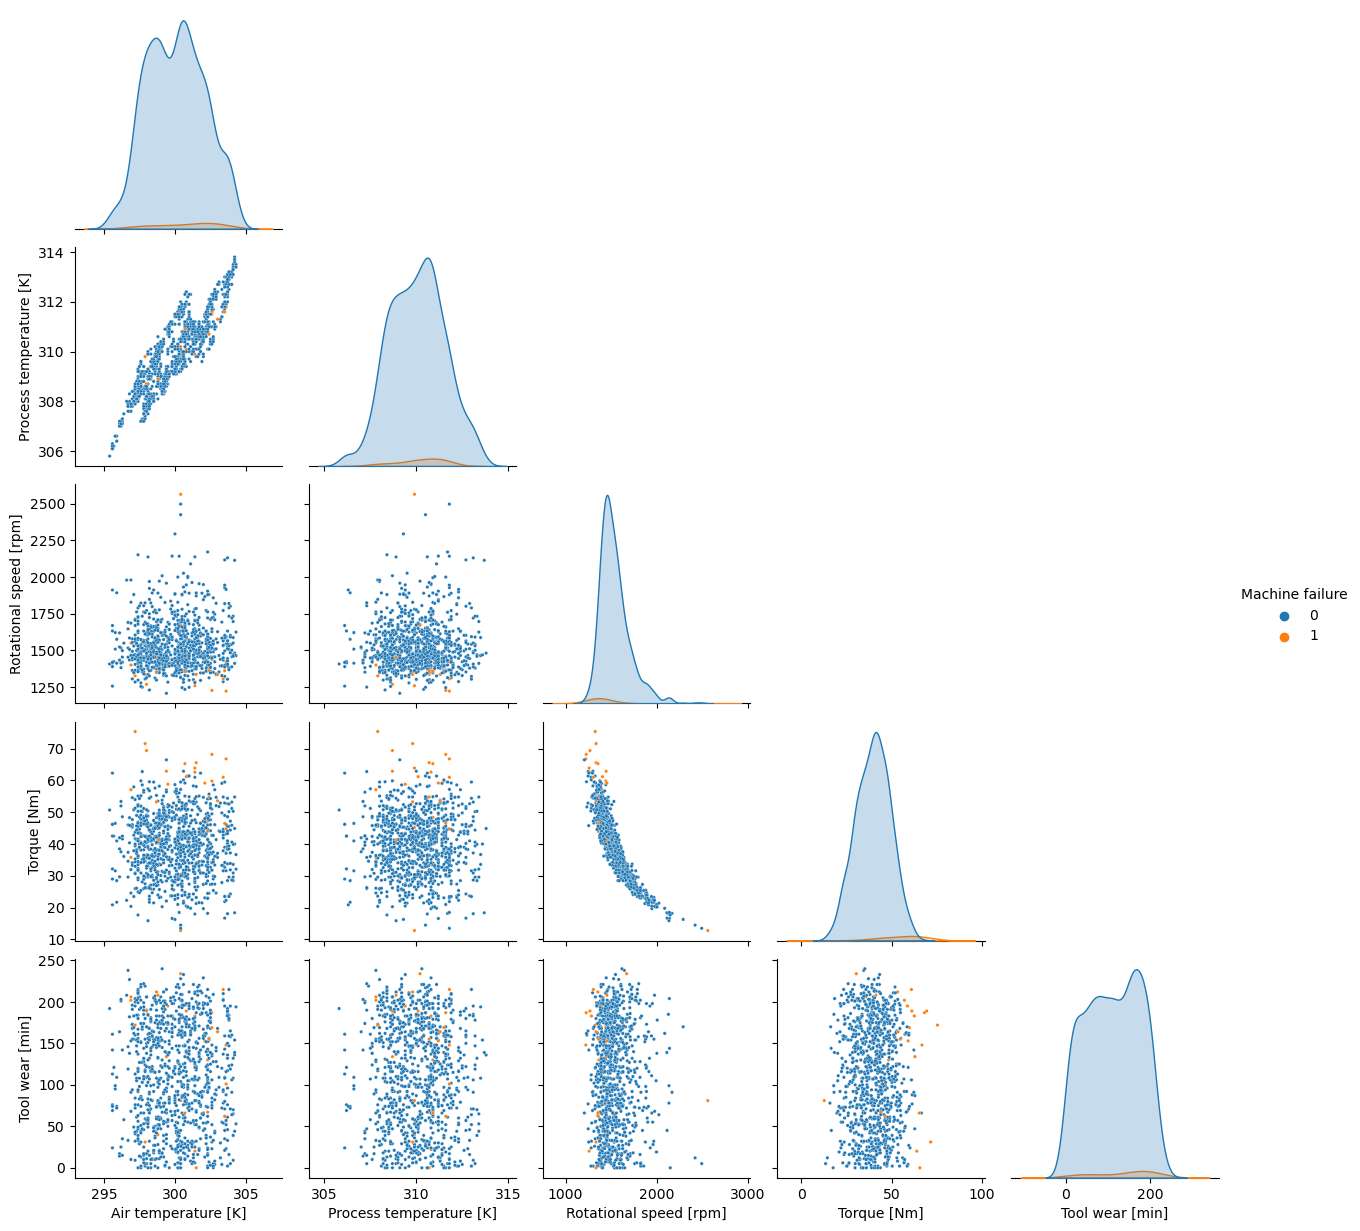

In [16]:
def plot_pair():
    sns.pairplot(data=df.drop(['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1).sample(1000).select_dtypes(include='number'),
                 hue='Machine failure',
                 plot_kws={'s':6},
                 corner=True)
    plt.show()

plot_pair()

In [17]:
df.rename(columns={'Machine failure':'machine_failure'} ,inplace=True)
machine_failure_summary = (df.groupby('machine_failure'))
machine_failure_summary.mean()

C:\Users\ODY1SZH\AppData\Local\Temp\ipykernel_4388\2695077136.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  machine_failure_summary.mean()


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
machine_failure,,,,,,,,,,,
0,5012.878791,299.973999,309.995570,1540.260014,39.629655,106.693717,0.000000,0.000000,0.000000,0.000000,0.001863
1,4647.722714,300.886431,310.290265,1496.486726,50.168142,143.781711,0.135693,0.339233,0.280236,0.289086,0.002950


C:\Users\ODY1SZH\AppData\Local\Temp\ipykernel_4388\535479581.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],machine_failure,TWF,HDF,PWF,OSF,RNF
UDI,1.000000,0.117428,0.324428,-0.006615,0.003207,-0.010702,-0.022892,0.009154,-0.022215,-0.023557,-0.000990,-0.005954
Air temperature [K],0.117428,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.009955,0.137831,0.003470,0.001988,0.017688
Process temperature [K],0.324428,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.007315,0.056933,-0.003355,0.004554,0.022279
Rotational speed [rpm],-0.006615,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,0.010389,-0.121241,0.123018,-0.104575,-0.013088
Torque [Nm],0.003207,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,-0.014662,0.142610,0.083781,0.183465,0.016136
Tool wear [min],-0.010702,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.115792,-0.001287,-0.009334,0.155894,0.011326
machine_failure,-0.022892,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.362904,0.575800,0.522812,0.531083,0.004516
TWF,0.009154,0.009955,0.007315,0.010389,-0.014662,0.115792,0.362904,1.000000,-0.007332,0.008577,0.038243,0.030970
HDF,-0.022215,0.137831,0.056933,-0.121241,0.142610,-0.001287,0.575800,-0.007332,1.000000,0.018443,0.046396,-0.004706
PWF,-0.023557,0.003470,-0.003355,0.123018,0.083781,-0.009334,0.522812,0.008577,0.018443,1.000000,0.115836,-0.004273


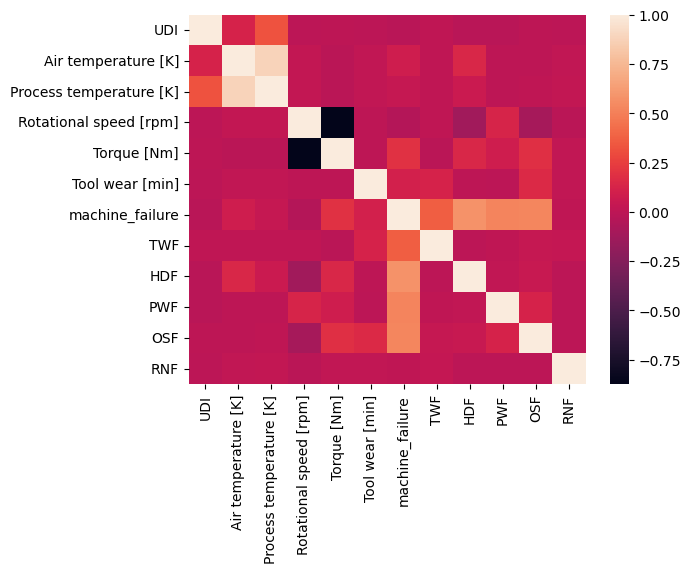

In [18]:
# correlation matrix
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

### Data preprocessing

In [19]:
def encoding_label(labelx):
    from sklearn import preprocessing
    newlabel = preprocessing.LabelEncoder()
    df[labelx] = newlabel.fit_transform(df[labelx])
    
    df[labelx].unique()
    return df

In [20]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'machine_failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [21]:
encoding_label('Product ID')
encoding_label('Type')

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],machine_failure,TWF,HDF,PWF,OSF,RNF
0,1,7003,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,1003,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,1004,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,1005,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,1006,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,9997,2,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,1001,0,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,9998,2,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,1002,0,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [22]:
df.rename(columns = {'Air temperature [K]':'Air_temp'}, inplace = True)
df.rename(columns={'Process temperature [K]':'Process_temp'} ,inplace=True)
df.rename(columns={'Rotational speed [rpm]':'Rotational_speed'} ,inplace=True)
df.rename(columns={'Torque [Nm]':'Torque'} ,inplace=True)
df.rename(columns={'Tool wear [min]':'Tool_wear'} ,inplace=True)
df.rename(columns={'Product ID':'ID'} ,inplace=True)
df

,UDI,ID,Type,Air_temp,Process_temp,Rotational_speed,Torque,Tool_wear,machine_failure,TWF,HDF,PWF,OSF,RNF
0,1,7003,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,1003,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,1004,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,1005,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,1006,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,9997,2,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,1001,0,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,9998,2,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,1002,0,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


### Feature Selection

In [23]:
df1 = df.drop(columns=['TWF','HDF','PWF','OSF','RNF','UDI'])

In [24]:
X = df1.drop('machine_failure',axis=1) #failed machine
Y = df1['machine_failure']

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

In [26]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8500, 7) (8500,)
(1500, 7) (1500,)


## Data modeling

### Decision Tree

In [27]:
dtree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_depth=3, 
    min_weight_fraction_leaf=0.01 
    )
# train
dtree = dtree.fit(X_train,Y_train)
# index caculation
dt_roc_auc = roc_auc_score(Y_test, dtree.predict(X_test))
print ("Desicion tree AUC = %2.2f" % dt_roc_auc)
print(classification_report(Y_test, dtree.predict(X_test)))

Desicion tree AUC = 0.64
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1459
           1       0.75      0.29      0.42        41

    accuracy                           0.98      1500
   macro avg       0.87      0.64      0.70      1500
weighted avg       0.97      0.98      0.97      1500



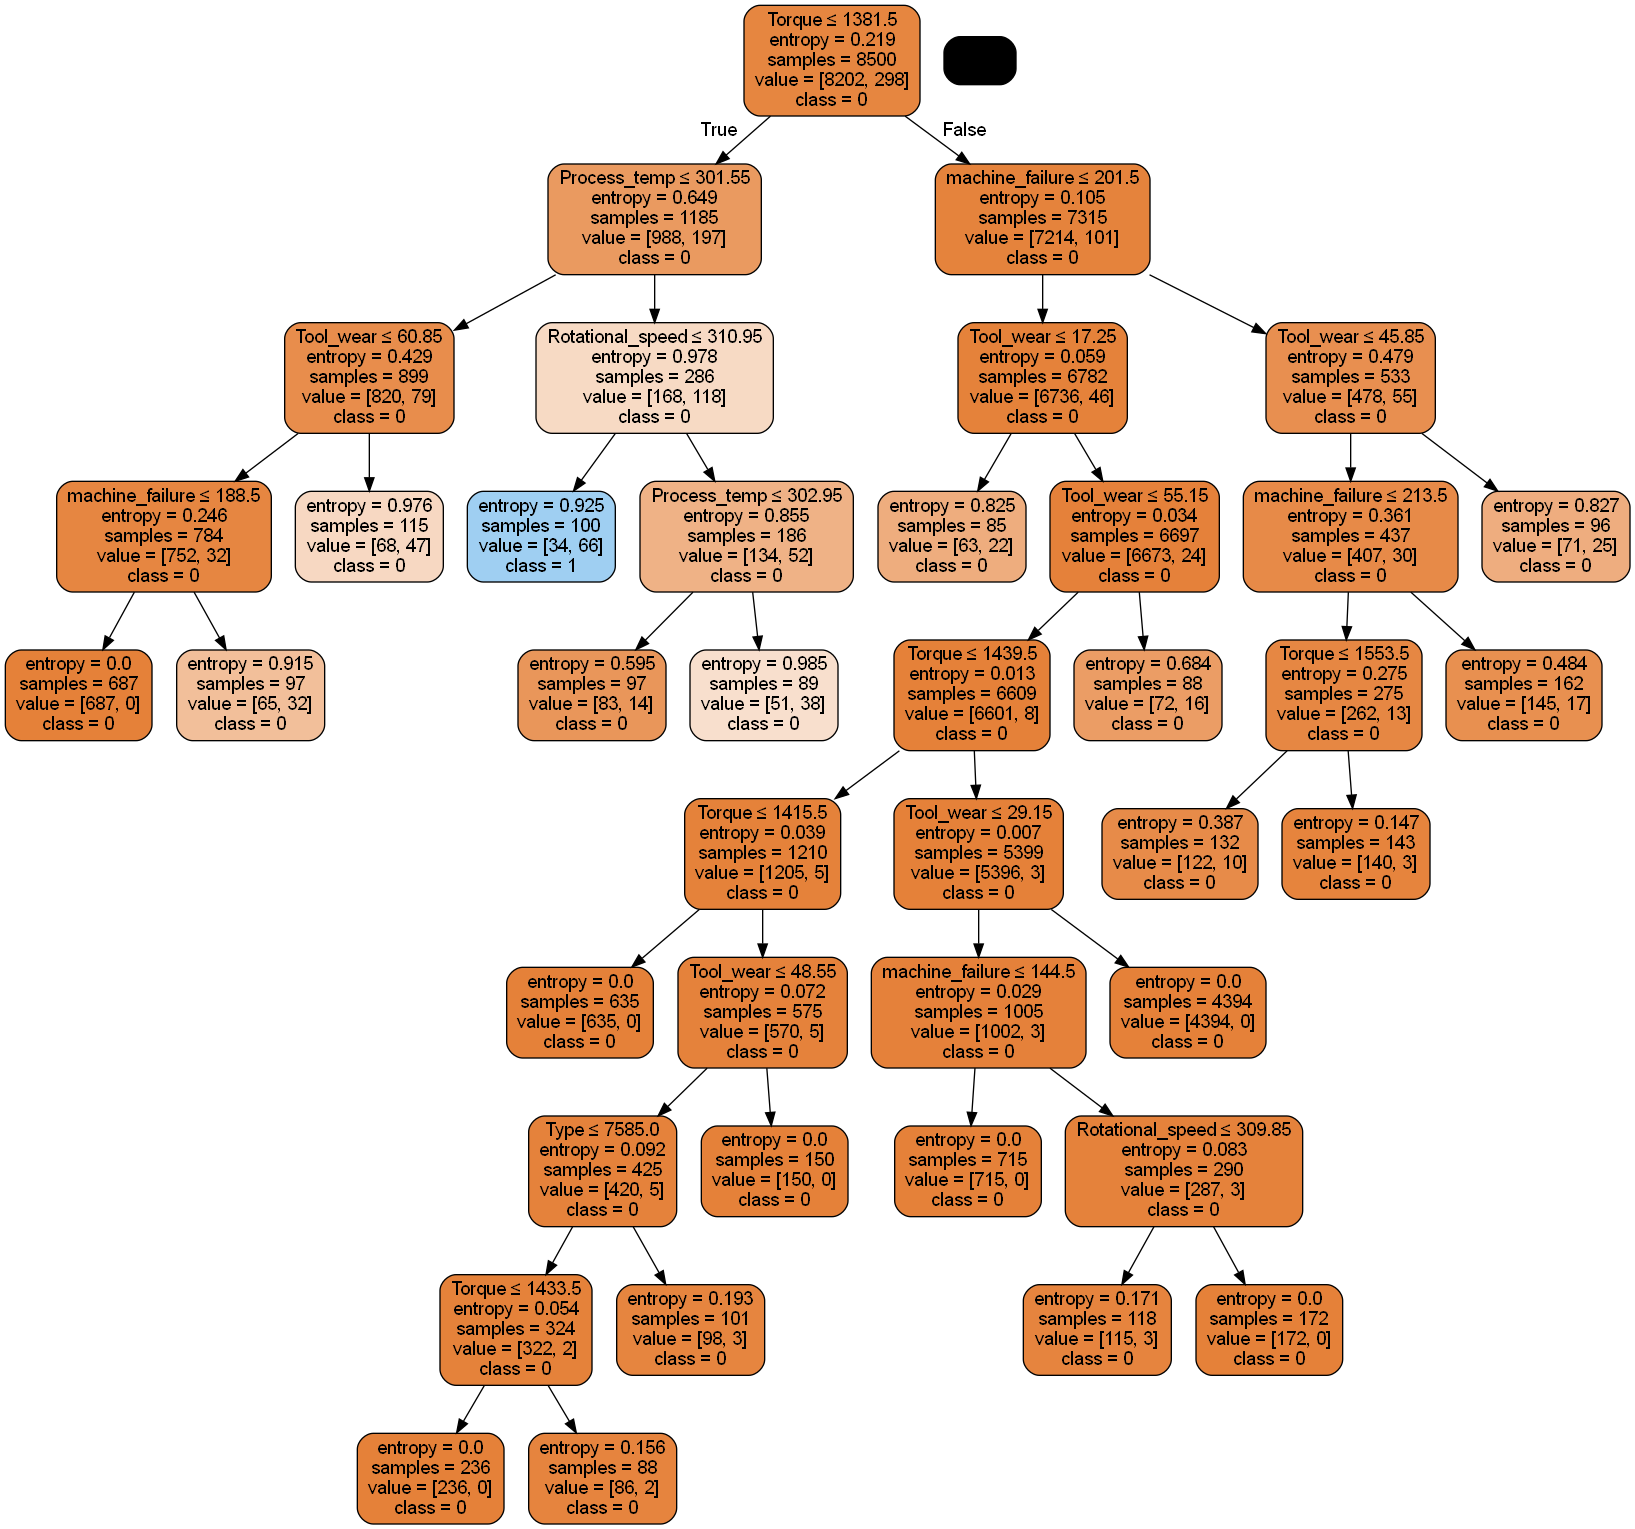

In [28]:
# feature vectors
feature_names = df1.columns[1:]
# 
dot_data = StringIO()
# import decision tree to the dot
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=['0','1'])
# generate gragh
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

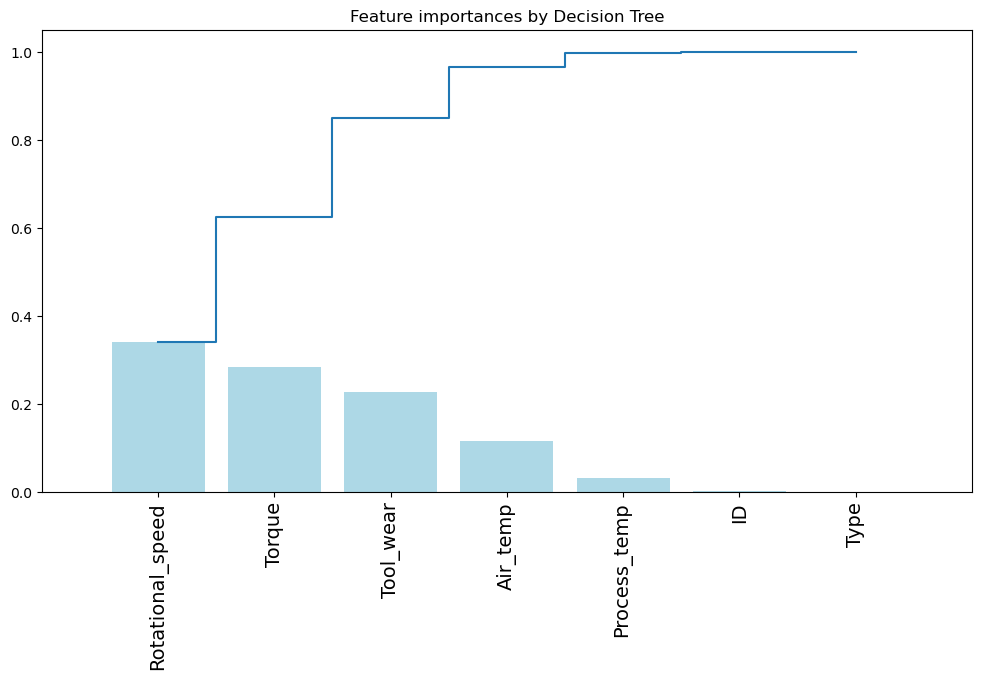

In [29]:
importances = dtree.feature_importances_
feat_names = df1.drop(["machine_failure"],axis=1).columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by Decision Tree")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

### Random Forest

In [30]:
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=3, 
    max_depth=None, 
    min_samples_split=10, 
    )
# training
rf.fit(X_train, Y_train)
rf_roc_auc = roc_auc_score(Y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(Y_test, rf.predict(X_test)))

Random Forest AUC = 0.79
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1459
           1       0.67      0.59      0.62        41

    accuracy                           0.98      1500
   macro avg       0.83      0.79      0.81      1500
weighted avg       0.98      0.98      0.98      1500



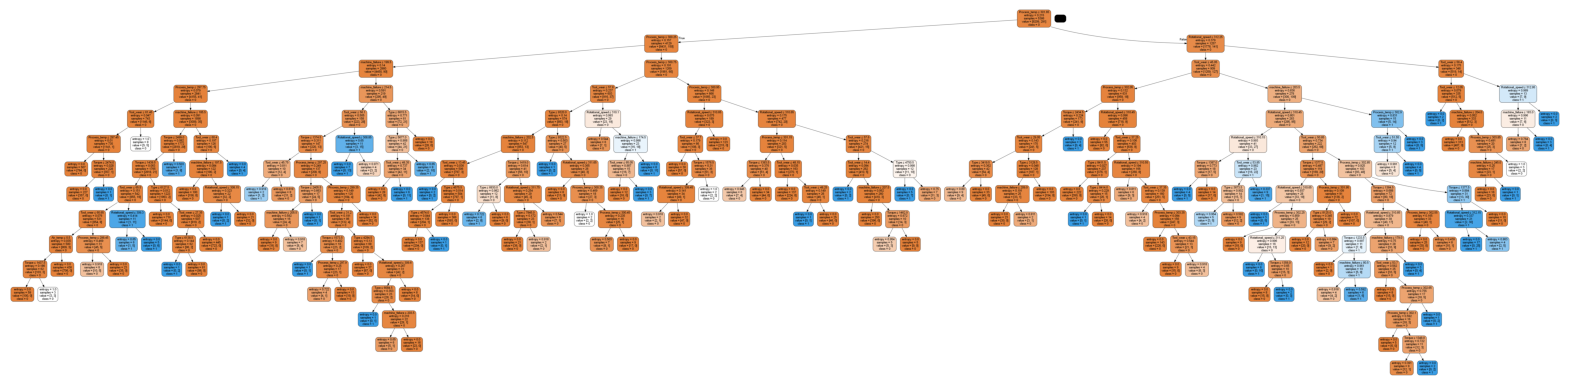

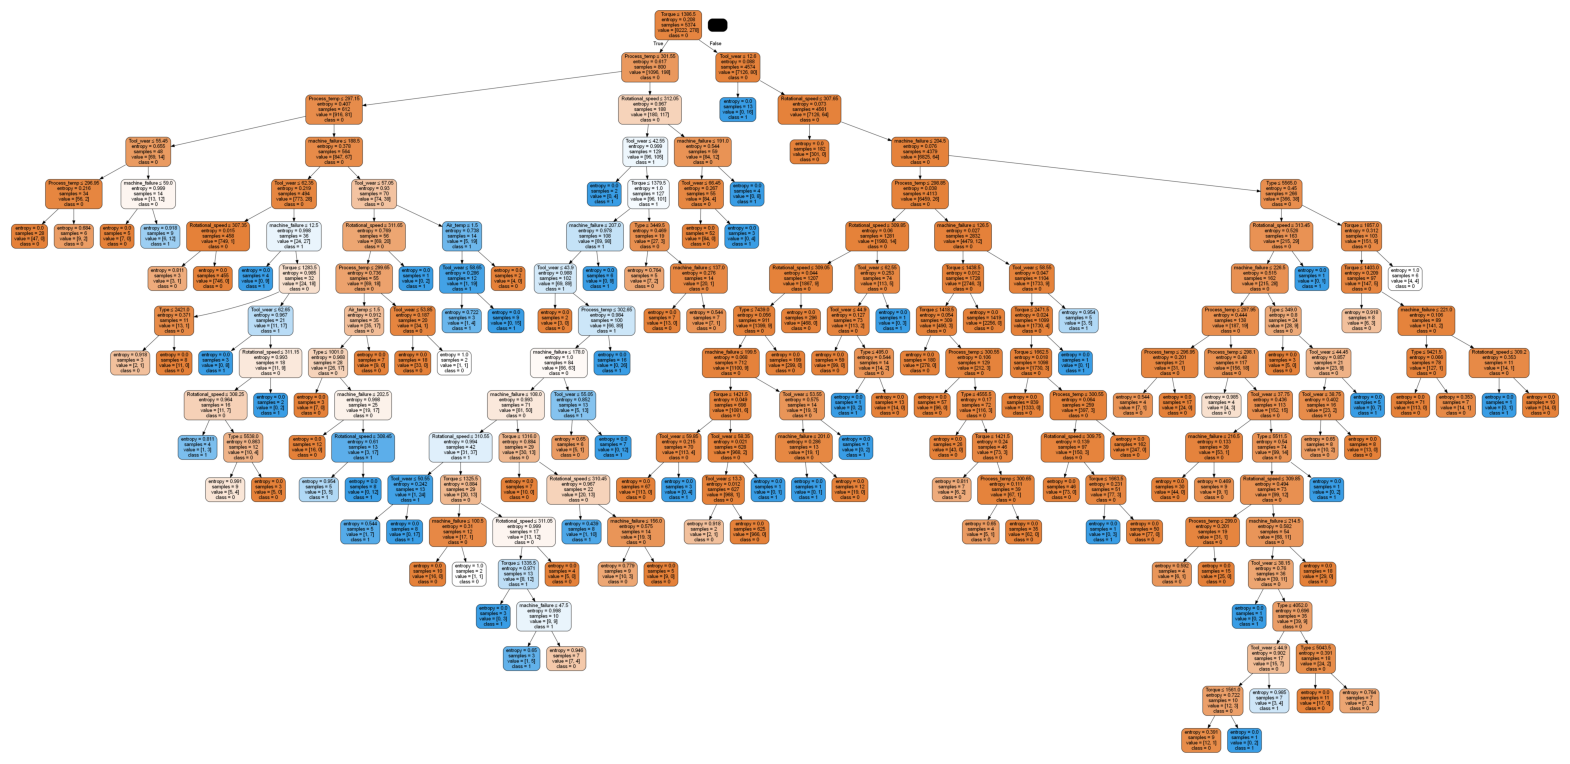

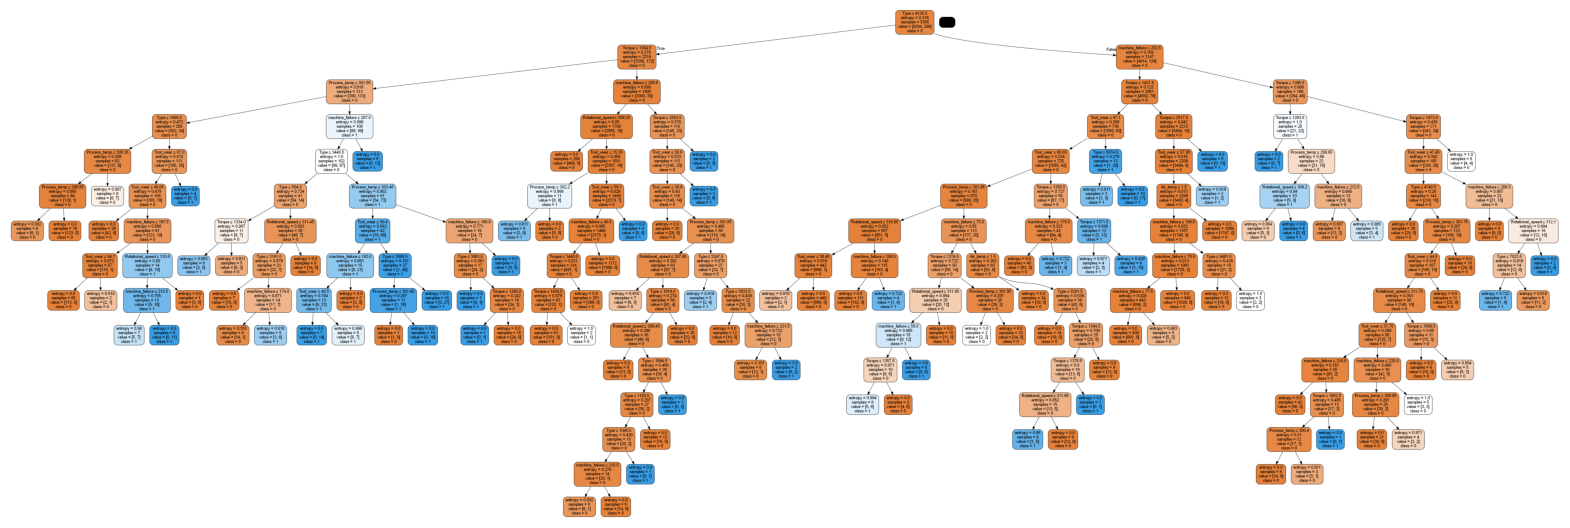

In [31]:
Estimators = rf.estimators_
# traverse
for index, model in enumerate(Estimators):
    # file cache
    dot_data = StringIO()
    # Import the decision tree into dot_data
    export_graphviz(model , out_file=dot_data,
                         feature_names=df1.columns[1:],
                         class_names=['0','1'],
                         filled=True, rounded=True,
                         special_characters=True)
    # Generate a graph from the data
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    # Write the result to a png file
    graph.write_png('Rf{}.png'.format(index))
    plt.figure(figsize = (20,20))
    plt.imshow(plt.imread('Rf{}.png'.format(index)))
    plt.axis('off')

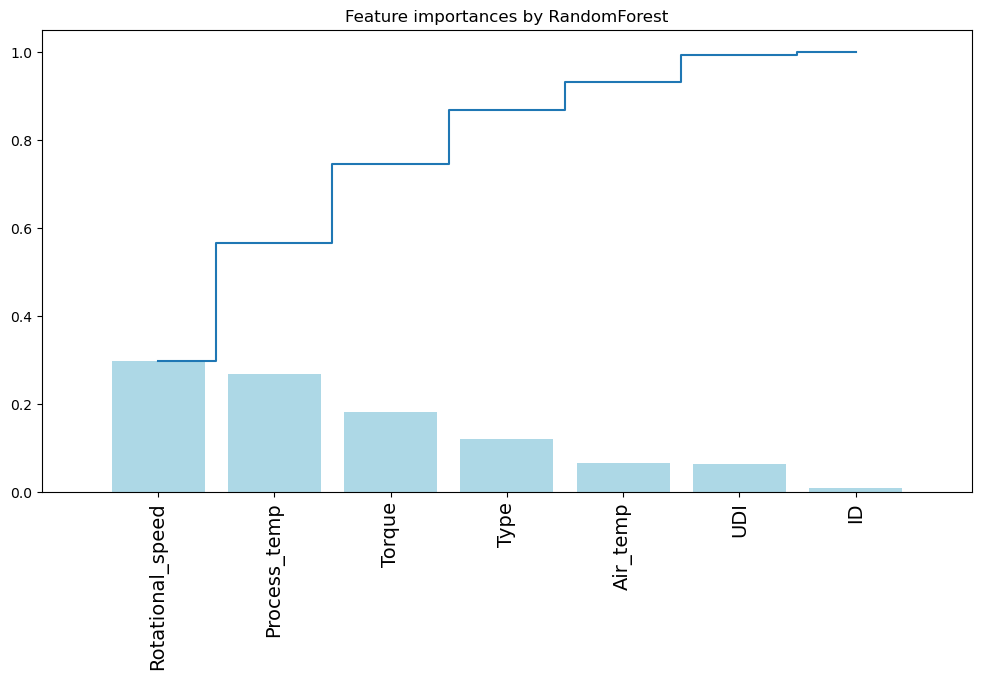

In [32]:
importances = rf.feature_importances_
feat_names = df.drop(['machine_failure'],axis=1).columns
# sort
indices = np.argsort(importances)[::-1]
# plot
plt.figure(figsize=(12,6))
plt.title("Feature importances by RandomForest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

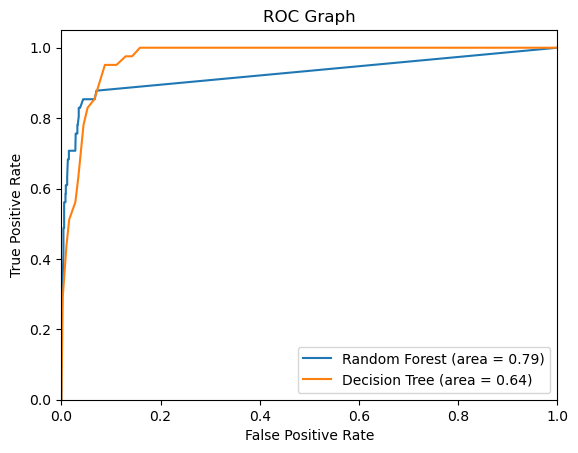

In [33]:
from sklearn.metrics import roc_curve
# Receiver operating characteristic curve
rf_fpr, rf_tpr, rf_thresholds = roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(Y_test, dtree.predict_proba(X_test)[:,1])


plt.figure()

# Random forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# decision tree ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
# plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

### Xgboost

In order for XGBoost to be able to use our data, we’ll need to transform it into a specific format that XGBoost can handle. That format is called DMatrix

In [34]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8500, 7) (8500,)
(1500, 7) (1500,)


In [35]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree

D_train = xgb.DMatrix(data=X_train, label=Y_train)
D_test = xgb.DMatrix(data=X_test, label=Y_test)

In [36]:
param1 = {
    'eta': 0.26,
    'max_depth': 3,
    'objective': 'multi:softprob',  
    'num_class': 5} 
num_round = 20  # The number of training iterations

In [37]:
param2 = {
    'eta': 0.8, 
    'max_depth': 6,  
    'objective': 'multi:softprob',  
    'num_class': 3}

In [38]:
from time import time
import datetime
print("The time of param１:")
t0 = time()
cvresult1 = xgb.cv(params=param1, dtrain=D_train, num_boost_round=num_round)
print(datetime.datetime.fromtimestamp(time()-t0).strftime("%M:%S:%f"))

t0 = time()
print("The time of param2:")
cvresult2 = xgb.cv(params=param2, dtrain=D_train, num_boost_round=num_round)
print(datetime.datetime.fromtimestamp(time()-t0).strftime("%M:%S:%f"))

The time of param１:
00:00:434840
The time of param2:
00:00:519127


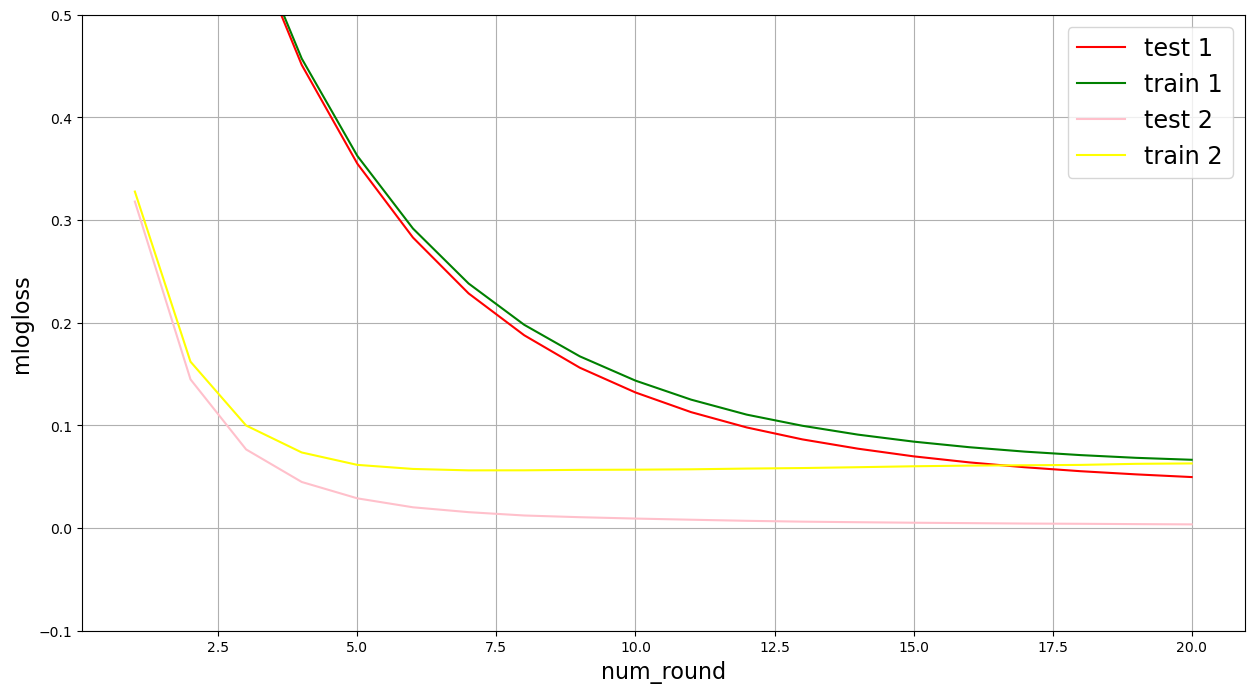

In [39]:
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.grid()
end = num_round + 1

ax.plot(range(1, end), cvresult1.iloc[:, 0], c="red", label="test 1")
ax.plot(range(1, end), cvresult1.iloc[:, 2], c="green", label="train 1")

ax.plot(range(1, end), cvresult2.iloc[:, 0], c="pink", label="test 2")
ax.plot(range(1, end), cvresult2.iloc[:, 2], c="yellow", label="train 2")

ax.legend(fontsize = "xx-large")
ax.set_ylim(bottom=-0.1, top=0.5)
plt.ylabel(cvresult1.columns[1].split("-")[1], fontsize=16)
plt.xlabel("num_round", fontsize=16)
plt.savefig("./cv.png")
plt.show()

In [40]:
model = xgb.train(param1, D_train,num_round)
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

Precision = 0.8774919110740007
Recall = 0.7418462361457062
Accuracy = 0.982


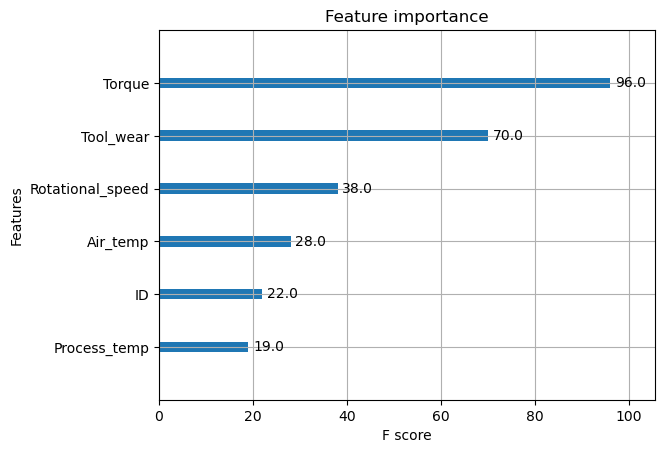

In [41]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [42]:
model.dump_model('dump.raw.txt')